In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [2]:
%%px
# Import the libraries

import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import math
import sys
import os
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB
import matplotlib
import matplotlib.pyplot as plt

from FFT3Dfield import FFT3Dfield
from IFFT3Dfield import IFFT3Dfield
from EnergySpectrum import EnergySpectrum

In [3]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']

In [4]:
%%px

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

[stdout:5] 
n_proc = 8
rank = 0


In [5]:
%%px 
# Computational Domain

nx=Nx//nproc
ny=Ny
nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

In [6]:
%%px

cacheEnstrophyData = False
loadEnstrophyFromCache = True

folder = "/home/idies/workspace/scratch"
filename = "enstrophy-newFFT-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(loadEnstrophyFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    w2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    w2[:,:,:] = content['w2']
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheEnstrophyData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,w2=w2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:5] 
Finished loading
Load from disk: 8.77 seconds


In [24]:
%%px
sigma2_w = np.sum(w2)
sigma2_g = np.zeros(1,dtype='float32')
comm.Reduce([sigma2_w,MPI.REAL],[sigma2_g,MPI.REAL],op=MPI.SUM)

sigma2_g = sigma2_g/(1024.0**3)
sigma2_g = comm.bcast(sigma2_g,root=0)
sigma2_g = sigma2_g[0]

In [8]:
%%px
comm.Barrier()
minw2 = w2.min()
maxw2 = w2.max()

comm.Barrier()

minwl = []
if(rank==0):
    minwl.append(minw2)
    for j in range(1,nproc):
        minw_r = comm.recv(source=j,tag=11)
        minwl.append(minw_r)
else:
    comm.send(minw2,dest=0,tag=11)

comm.Barrier()

maxwl = []
if(rank==0):
    maxwl.append(maxw2)
    for j in range(1,nproc):
        maxw_r = comm.recv(source=j,tag=11)
        maxwl.append(maxw_r)
else:
    comm.send(maxw2,dest=0,tag=11)

comm.Barrier()

if(rank==0):
    m = min(minwl)
    M = max(maxwl)
    
comm.Barrier()

if(rank==0):
    for j in range(1,nproc):
        comm.send(m,dest=j,tag=22)
else:
    m=comm.recv(source=0,tag=22)
    
comm.Barrier()

if(rank==0):
    for j in range(1,nproc):
        comm.send(M,dest=j,tag=22)
else:
    M=comm.recv(source=0,tag=22)
    
comm.Barrier()

if(rank==0):
    print("minw = "+str(m/sigma2g))
    print("maxw = "+str(M/sigma2g))


[stdout:5] 
minw = 9.39153e-08
maxw = 460.222


In [9]:
%%px

from Statistics import Statistics

In [10]:
%%px 

st = Statistics()

In [11]:
%%px
Nbins = 3200
pdf=st.FindPDF(w2/sigma2g,m/sigma2g,M/sigma2g,Nbins,nx,ny,nz,nproc)

[output:5]

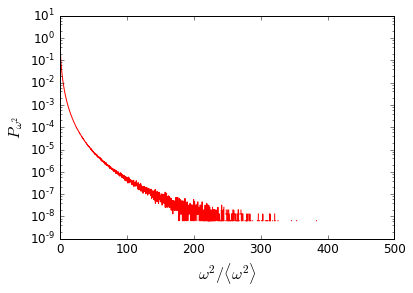

In [12]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
w2histo[-1] = 0
if rank==0:
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')

    plt.semilogy(pdf[0,:],pdf[1,:],'r',label='Unfiltered')

In [13]:
%%px

w2temp = w2[w2<=5*sigma2g]
Nbins = 400
pdf=st.FindPDF(w2temp/sigma2g,m/sigma2g,5,Nbins,nx,ny,nz,nproc)

In [18]:
%%px
Nbins = 400
wtemp = w2[w2<=5*sigma2g] 
w2red=np.zeros(Nbins,dtype='int')
histred,edgesred = np.histogram(wtemp/sigma2g,np.linspace(m/sigma2g, 5, Nbins))
#hist,edges = np.histogram(w2/sigma2g,10 ** np.linspace(np.log10(m/sigma2g), np.log10(M/sigma2g), Nbins))

In [19]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[w2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

[output:5]

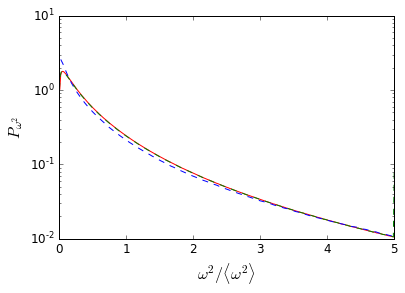

In [21]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
w2histo[-1] = 0
if rank==0:
    w2_bins = np.load('enstrophy_bins.npy')
    w2_pdf = np.load('enstrophy_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')

    plt.semilogy(pdf[0,:],pdf[1,:],'r',label='Unfiltered')
    plt.semilogy(w2_bins[w2_bins<=5],w2_pdf[w2_bins<=5],'b--')
    plt.semilogy(edgesred,(w2red*(1024**(-3)))/((5*sigma2g-m)/(sigma2g*Nbins)),'g--',label='Unfiltered')